In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras


import flwr as fl
import matplotlib.pyplot as plt
import numpy as np 
from typing import List, Tuple
from flwr.common import Metrics

import ray
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()


2024-02-13 21:47:02.118242: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 21:47:02.143964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 21:47:02.144015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 21:47:02.144626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 21:47:02.149554: I tensorflow/core/platform/cpu_feature_guar

# Data Processing

In [2]:
def getMnistData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'mnist',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [3]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255 

In [4]:
trainset,testset, info = getMnistData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)


2024-02-13 21:47:03.637462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 21:47:03.637701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 21:47:03.637784: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

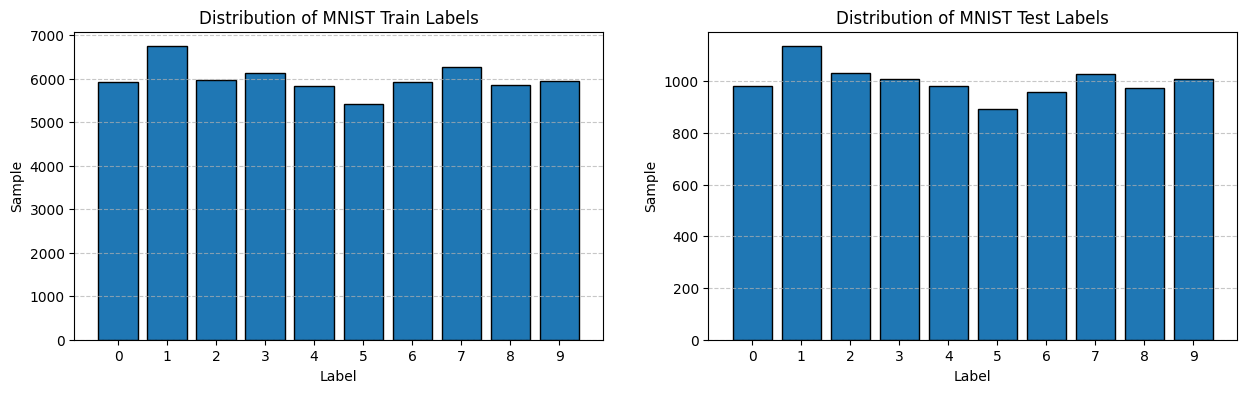

In [5]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of MNIST Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of MNIST Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [6]:
def split_into_partition(data, labels, num_partitions):
    # Combine data and labels
    combined_data = list(zip(data, labels))
    np.random.shuffle(combined_data)  # Shuffle the combined data randomly

    partitions = [[] for _ in range(num_partitions)]
    store_label = np.unique(labels).tolist()
    counter = 0
    count = 0
    # Iterate over unique labels to efficiently distribute them across partitions
    while store_label:
        random_choice = np.random.choice(store_label)

        # Extract data and labels for the selected class
        class_data = [item[0] for item in combined_data if item[1] == random_choice]
        class_labels = [random_choice] * len(class_data)

        # Distribute the class data evenly among partitions
        modnum = len(np.unique(labels)) // num_partitions

        if counter == (num_partitions - 1):
            partitions[counter].extend(list(zip(class_data, class_labels)))
        elif count <= modnum:
            # Extend the selected partition with the data and labels
            count+=1
            partitions[counter].extend(list(zip(class_data, class_labels)))
            if count == modnum:
                counter += 1
                count=0


        store_label.remove(random_choice)

   # Separate data and labels after partitioning
    data_partitions = [np.array(list(zip(*partition))[0]) if partition else np.array([]) for partition in partitions]
    label_partitions = [np.array(list(zip(*partition))[1]) if partition else np.array([]) for partition in partitions]


    return data_partitions, label_partitions

In [7]:
NumOfPartition = 3
train_image_part,train_label_part = split_into_partition(Train_images_n,Train_label,NumOfPartition)

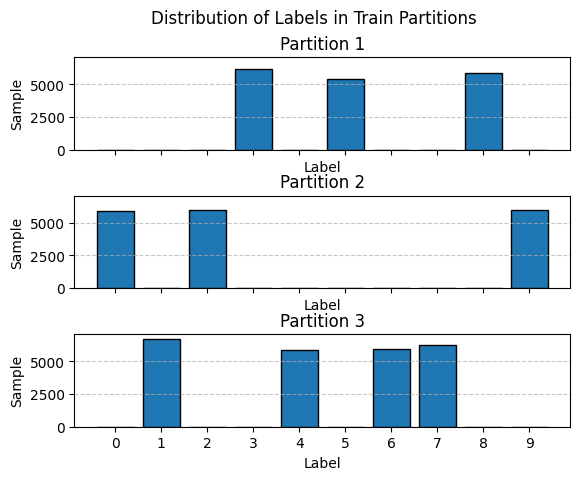

In [8]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

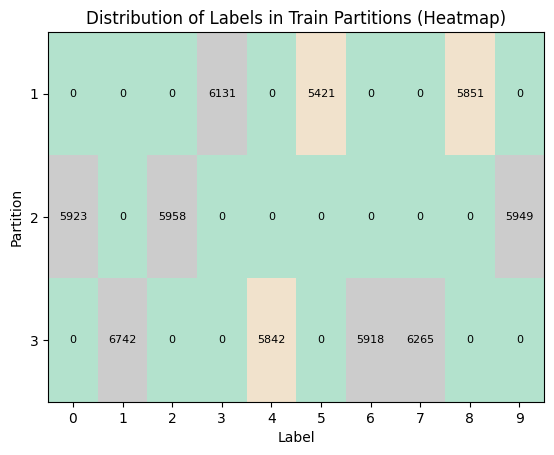

In [9]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [10]:
def simpleRNNModel():
    model = keras.Sequential()    
    model.add(keras.layers.LSTM(128, input_shape=(28, 28)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model
        
    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set, 
                                 y=self.train_label_set,
                                 verbose=2, 
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")       
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")       
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [12]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 33,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]
    
    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [13]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [14]:
globalmodel = simpleRNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)


2024-02-13 21:47:10.152959: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [15]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
        ray_init_args ={
            "include_dashboard": True, # we need this one for tracking,
        },
        actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth # <-- To be executed upon actor init.
    },
        client_resources = {'num_cpus': 8, 'num_gpus': 1}, # A Python dict specifying CPU/GPU resources
    )

INFO flwr 2024-02-13 21:47:10,313 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-13 21:47:12,089	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2024-02-13 21:47:12,814 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7776637748.0, 'node:10.91.229.129': 1.0, 'object_store_memory': 3888318873.0, 'CPU': 16.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7776637748.0, 'node:10.91.229.129': 1.0, 'object_store_memory': 3888318873.0, 'CPU': 16.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2024-02-13 21:47:12,815 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Opti

(DefaultActor pid=29573) round :1
(DefaultActor pid=29573) Train :17403
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33


(DefaultActor pid=29573) 2024-02-13 21:47:15.921929: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
(DefaultActor pid=29573) 2024-02-13 21:47:16.000373: I external/local_xla/xla/service/service.cc:168] XLA service 0x55fc73ace640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(DefaultActor pid=29573) 2024-02-13 21:47:16.000409: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
(DefaultActor pid=29573) 2024-02-13 21:47:16.004392: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
(DefaultActor pid=29573) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(DefaultActor pid=29573) I0000 00:00:1707832036.068778   29730 device_compiler.h:186] Compiled cluster using XLA!  This line i

(DefaultActor pid=29573) 544/544 - 3s - loss: 0.3752 - accuracy: 0.8519 - val_loss: 6.5998 - val_accuracy: 0.2714 - 3s/epoch - 6ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.1120 - accuracy: 0.9621 - val_loss: 7.1829 - val_accuracy: 0.2792 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0736 - accuracy: 0.9753 - val_loss: 7.0460 - val_accuracy: 0.2816 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0538 - accuracy: 0.9820 - val_loss: 6.7383 - val_accuracy: 0.2828 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 1s - loss: 0.0440 - accuracy: 0.9860 - val_loss: 6.8908 - val_accuracy: 0.2849 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0354 - accuracy: 0.9875 - val_loss: 7.1807 - val_accuracy: 0.2838 - 2s/epoch - 3ms/step
(Def

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :1
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 3s - loss: 0.1855 - accuracy: 0.9313 - val_loss: 6.5197 - val_accuracy: 0.2987 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0405 - accuracy: 0.9870 - val_loss: 5.9434 - val_accuracy: 0.2993 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0291 - accuracy: 0.9908 - val_loss: 6.6058 - val_accuracy: 0.2994 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0209 - accuracy: 0.9937 - val_loss: 6.2596 - val_accuracy: 0.2992 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0185 - accuracy: 0.9943 - val_loss: 6.6720 - val_accuracy: 0.3006 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.1910 - accuracy: 0.9323 - val_loss: 5.0538 - val_accuracy: 0.4009 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0499 - accuracy: 0.9849 - val_loss: 6.0276 - val_accuracy: 0.4058 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0343 - accuracy: 0.9894 - val_loss: 6.0609 - val_accuracy: 0.4055 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0299 - accuracy: 0.9905 - val_loss: 5.8331 - val_accuracy: 0.4070 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0236 - accuracy: 0.9918 - val_loss: 6.0515 - val_accuracy: 0.4073 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0200 - accuracy: 0.9937 - val_loss: 6.8697 - val_accurac

DEBUG flwr 2024-02-13 21:50:15,213 | server.py:236 | fit_round 1 received 3 results and 0 failures
DEBUG:flwr:fit_round 1 received 3 results and 0 failures
DEBUG flwr 2024-02-13 21:50:15,215 | server.py:173 | evaluate_round 1: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 1: strategy sampled 3 clients (out of 3)
(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0037 - accuracy: 0.9990 - val_loss: 11.0153 - val_accuracy: 0.4076 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!
(DefaultActor pid=29573) 10000/10000 - 10s - loss: 2.9853 - accuracy: 0.2990 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 2.9853 - accuracy: 0.2990 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 21:50:47,094 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2024-02-13 21:50:47,095 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 2: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 2.9853 - accuracy: 0.2990 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :2
(DefaultActor pid=29573) Train :17403
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 3s - loss: 0.1782 - accuracy: 0.9366 - val_loss: 7.5847 - val_accuracy: 0.2855 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0379 - accuracy: 0.9877 - val_loss: 6.9052 - val_accuracy: 0.2850 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0276 - accuracy: 0.9909 - val_loss: 7.1703 - val_accuracy: 0.2854 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0213 - accuracy: 0.9930 - val_loss: 6.6253 - val_accuracy: 0.2854 - 2s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0171 - accuracy: 0.9941 - val_loss: 6.9563 - val_accuracy: 0.2844 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :2
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.1102 - accuracy: 0.9692 - val_loss: 8.1246 - val_accuracy: 0.2995 - 2s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 1s - loss: 0.0160 - accuracy: 0.9958 - val_loss: 6.9740 - val_accuracy: 0.3000 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0127 - accuracy: 0.9967 - val_loss: 7.4142 - val_accuracy: 0.3054 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0089 - accuracy: 0.9972 - val_loss: 7.4205 - val_accuracy: 0.3001 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0089 - accuracy: 0.9971 - val_loss: 6.7890 - val_accuracy: 0.3042 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0274 - accuracy: 0.9925 - val_loss: 7.2401 - val_accuracy: 0.4074 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0115 - accuracy: 0.9961 - val_loss: 7.2734 - val_accuracy: 0.4083 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0086 - accuracy: 0.9970 - val_loss: 7.6145 - val_accuracy: 0.4084 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0102 - accuracy: 0.9970 - val_loss: 7.5923 - val_accuracy: 0.4080 - 2s/epoch - 2ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0066 - accuracy: 0.9979 - val_loss: 7.3864 - val_accuracy: 0.4070 - 2s/epoch - 2ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0083 - accuracy: 0.9976 - val_loss: 7.8664 - val_accurac

DEBUG flwr 2024-02-13 21:53:47,844 | server.py:236 | fit_round 2 received 3 results and 0 failures
DEBUG:flwr:fit_round 2 received 3 results and 0 failures
DEBUG flwr 2024-02-13 21:53:47,847 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 2: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0049 - accuracy: 0.9988 - val_loss: 10.8915 - val_accuracy: 0.4088 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 3.1529 - accuracy: 0.3993 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 3.1529 - accuracy: 0.3993 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 21:54:19,732 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2024-02-13 21:54:19,732 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 3: strategy sampled 3 clients (out of 3)
(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 3.1529 - accuracy: 0.3993 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!
(DefaultActor pid=29573) round :3
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0778 - accuracy: 0.9808 - val_loss: 7.4827 - val_accuracy: 0.3293 - 2s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0100 - accuracy: 0.9973 - val_loss: 6.4568 - val_accuracy: 0.3376 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0037 - accuracy: 0.9989 - val_loss: 8.0064 - val_accuracy: 0.3245 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0027 - accuracy: 0.9993 - val_loss: 8.0598 - val_accuracy: 0.3051 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :3
(DefaultActor pid=29573) Train :24767
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0098 - accuracy: 0.9972 - val_loss: 8.0244 - val_accuracy: 0.4084 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0039 - accuracy: 0.9989 - val_loss: 8.8560 - val_accuracy: 0.4084 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0058 - accuracy: 0.9983 - val_loss: 8.2370 - val_accuracy: 0.4082 - 3s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0025 - accuracy: 0.9992 - val_loss: 8.1645 - val_accuracy: 0.4080 - 3s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0051 - accuracy: 0.9983 - val_loss: 8.4322 - val_accuracy: 0.4084 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 3s - loss: 0.1155 - accuracy: 0.9647 - val_loss: 7.5250 - val_accuracy: 0.2957 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 1s - loss: 0.0188 - accuracy: 0.9943 - val_loss: 7.8291 - val_accuracy: 0.2849 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0132 - accuracy: 0.9957 - val_loss: 6.9550 - val_accuracy: 0.2922 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0109 - accuracy: 0.9963 - val_loss: 7.0611 - val_accuracy: 0.2864 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0070 - accuracy: 0.9977 - val_loss: 7.9560 - val_accuracy: 0.2868 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0094 - accuracy: 0.9974 - val_loss: 7.0391 - val_accurac

DEBUG flwr 2024-02-13 21:57:20,674 | server.py:236 | fit_round 3 received 3 results and 0 failures
DEBUG:flwr:fit_round 3 received 3 results and 0 failures
DEBUG flwr 2024-02-13 21:57:20,676 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 3: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0060 - accuracy: 0.9983 - val_loss: 9.8955 - val_accuracy: 0.2862 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 4.0974 - accuracy: 0.4120 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 4.0974 - accuracy: 0.4120 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 21:57:52,446 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2024-02-13 21:57:52,447 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 4: strategy sampled 3 clients (out of 3)
(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 4.0974 - accuracy: 0.4120 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!
(DefaultActor pid=29573) round :4
(DefaultActor pid=29573) Train :24767
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0047 - accuracy: 0.9986 - val_loss: 8.4372 - val_accuracy: 0.4088 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0021 - accuracy: 0.9994 - val_loss: 8.2440 - val_accuracy: 0.4078 - 2s/epoch - 2ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0025 - accuracy: 0.9992 - val_loss: 9.0747 - val_accuracy: 0.4089 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0021 - accuracy: 0.9994 - val_loss: 9.1586 - val_accuracy: 0.4082 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :4
(DefaultActor pid=29573) Train :17403
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0998 - accuracy: 0.9741 - val_loss: 7.8545 - val_accuracy: 0.3010 - 2s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0099 - accuracy: 0.9968 - val_loss: 8.2185 - val_accuracy: 0.2999 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0062 - accuracy: 0.9983 - val_loss: 8.6995 - val_accuracy: 0.2902 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0033 - accuracy: 0.9989 - val_loss: 8.9005 - val_accuracy: 0.2914 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0063 - accuracy: 0.9981 - val_loss: 7.4809 - val_accuracy: 0.2995 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 3s - loss: 0.0999 - accuracy: 0.9788 - val_loss: 6.5124 - val_accuracy: 0.3395 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0067 - accuracy: 0.9984 - val_loss: 8.2740 - val_accuracy: 0.3183 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0033 - accuracy: 0.9990 - val_loss: 7.3575 - val_accuracy: 0.3240 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 8.1681 - val_accuracy: 0.3162 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 558/558 - 1s - loss: 0.0066 - accuracy: 0.9980 - val_loss: 6.7028 - val_accuracy: 0.3087 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0040 - accuracy: 0.9987 - val_loss: 7.2797 - val_accurac

DEBUG flwr 2024-02-13 22:00:52,051 | server.py:236 | fit_round 4 received 3 results and 0 failures
DEBUG:flwr:fit_round 4 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:00:52,054 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 4: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 558/558 - 2s - loss: 1.8219e-08 - accuracy: 1.0000 - val_loss: 12.3274 - val_accuracy: 0.3099 - 2s/epoch - 4ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 3.9295 - accuracy: 0.4327 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 3.9295 - accuracy: 0.4327 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 22:01:24,788 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:01:24,789 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 5: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 3.9295 - accuracy: 0.4327 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :5
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 3s - loss: 0.0688 - accuracy: 0.9858 - val_loss: 6.3160 - val_accuracy: 0.3918 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0037 - accuracy: 0.9988 - val_loss: 5.8301 - val_accuracy: 0.3853 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 1s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 6.6281 - val_accuracy: 0.3741 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0033 - accuracy: 0.9990 - val_loss: 6.6280 - val_accuracy: 0.3757 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0033 - accuracy: 0.9992 - val_loss: 6.4690 - val_accuracy: 0.3587 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 3s - loss: 0.0653 - accuracy: 0.9829 - val_loss: 6.5935 - val_accuracy: 0.3186 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0060 - accuracy: 0.9980 - val_loss: 8.0430 - val_accuracy: 0.3033 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0032 - accuracy: 0.9990 - val_loss: 7.7524 - val_accuracy: 0.3090 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 7.8434 - val_accuracy: 0.3119 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0042 - accuracy: 0.9989 - val_loss: 7.5579 - val_accuracy: 0.3073 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0051 - accuracy: 0.9986 - val_loss: 7.3548 - val_accurac

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :5
(DefaultActor pid=29573) Train :24767
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0021 - accuracy: 0.9994 - val_loss: 8.7706 - val_accuracy: 0.4086 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 8.5583 - val_accuracy: 0.4075 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0010 - accuracy: 0.9997 - val_loss: 9.7136 - val_accuracy: 0.4086 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 9.9026 - val_accuracy: 0.4085 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0035 - accuracy: 0.9987 - val_loss: 9.8137 - val_accuracy: 0.4083 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 

DEBUG flwr 2024-02-13 22:04:26,180 | server.py:236 | fit_round 5 received 3 results and 0 failures
DEBUG:flwr:fit_round 5 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:04:26,183 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 5: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 774/774 - 2s - loss: 8.1651e-04 - accuracy: 0.9999 - val_loss: 10.5022 - val_accuracy: 0.4086 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 3.3377 - accuracy: 0.4761 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 3.3377 - accuracy: 0.4761 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 22:04:58,206 | server.py:187 | evaluate_round 5 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:04:58,207 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 6: strategy sampled 3 clients (out of 3)
(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 3.3377 - accuracy: 0.4761 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!
(DefaultActor pid=29573) round :6
(DefaultActor pid=29573) Train :24767
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 8.3952 - val_accuracy: 0.4086 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 7.7136e-04 - accuracy: 0.9998 - val_loss: 9.0039 - val_accuracy: 0.4088 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0024 - accuracy: 0.9992 - val_loss: 9.5450 - val_accuracy: 0.4084 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 10.2816 - val_accuracy: 0.4085 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :6
(DefaultActor pid=29573) Train :17403
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0406 - accuracy: 0.9891 - val_loss: 7.3411 - val_accuracy: 0.3244 - 2s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 8.1330 - val_accuracy: 0.3130 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 2.5219e-04 - accuracy: 1.0000 - val_loss: 8.5758 - val_accuracy: 0.3104 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 3.9354e-04 - accuracy: 0.9999 - val_loss: 9.0183 - val_accuracy: 0.3130 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0105 - accuracy: 0.9964 - val_loss: 7.0120 - val_accuracy: 0.3039 - 2s/epoch - 3ms/step
(DefaultActor pid=29573

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :6
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 3s - loss: 0.0578 - accuracy: 0.9887 - val_loss: 6.4311 - val_accuracy: 0.3443 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 1s - loss: 0.0026 - accuracy: 0.9992 - val_loss: 6.2419 - val_accuracy: 0.3416 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 1s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 7.3413 - val_accuracy: 0.3304 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0029 - accuracy: 0.9993 - val_loss: 7.5458 - val_accuracy: 0.3263 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 1.2267e-04 - accuracy: 1.0000 - val_loss: 8.1993 - val_accuracy: 0.3218 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Ep

DEBUG flwr 2024-02-13 22:08:01,142 | server.py:236 | fit_round 6 received 3 results and 0 failures
DEBUG:flwr:fit_round 6 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:08:01,145 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 6: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 558/558 - 2s - loss: 1.0129e-08 - accuracy: 1.0000 - val_loss: 12.0594 - val_accuracy: 0.3146 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 3.4051 - accuracy: 0.5127 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 3.4051 - accuracy: 0.5127 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 22:08:33,167 | server.py:187 | evaluate_round 6 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:08:33,168 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 7: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 3.4051 - accuracy: 0.5127 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :7
(DefaultActor pid=29573) Train :24767
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0019 - accuracy: 0.9994 - val_loss: 9.2963 - val_accuracy: 0.4088 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 8.5841e-04 - accuracy: 0.9997 - val_loss: 9.5767 - val_accuracy: 0.4086 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 9.8671e-05 - accuracy: 1.0000 - val_loss: 9.8986 - val_accuracy: 0.4085 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 2.0410e-05 - accuracy: 1.0000 - val_loss: 10.1009 - val_accuracy: 0.4084 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 7.8989e-06 - accuracy: 1.0000 - val_loss: 10.2156 - val_accuracy: 0.4086 - 2s/epoch - 3ms/step
(DefaultActor

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :7
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0561 - accuracy: 0.9889 - val_loss: 5.6111 - val_accuracy: 0.4303 - 2s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 6.5528e-04 - accuracy: 0.9999 - val_loss: 6.3521 - val_accuracy: 0.4163 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 1.0449e-04 - accuracy: 1.0000 - val_loss: 6.8456 - val_accuracy: 0.4084 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 4.3575e-05 - accuracy: 1.0000 - val_loss: 7.1077 - val_accuracy: 0.4049 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 2.7971e-05 - accuracy: 1.0000 - val_loss: 7.3417 - val_accuracy: 0.4004 - 2s/epoch - 3ms/step
(DefaultActor p

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 3s - loss: 0.0368 - accuracy: 0.9910 - val_loss: 6.8562 - val_accuracy: 0.3517 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0010 - accuracy: 0.9998 - val_loss: 7.5967 - val_accuracy: 0.3348 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 7.2111e-04 - accuracy: 0.9998 - val_loss: 7.6905 - val_accuracy: 0.3255 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0076 - accuracy: 0.9978 - val_loss: 7.9941 - val_accuracy: 0.2881 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 8.4635 - val_accuracy: 0.2860 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0025 - accuracy: 0.9991 - val_loss: 8.2096 - val_acc

DEBUG flwr 2024-02-13 22:11:34,475 | server.py:236 | fit_round 7 received 3 results and 0 failures
DEBUG:flwr:fit_round 7 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:11:34,479 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 7: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 544/544 - 2s - loss: 4.9648e-07 - accuracy: 1.0000 - val_loss: 11.6766 - val_accuracy: 0.2900 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 1.4498 - accuracy: 0.7312 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 1.4498 - accuracy: 0.7312 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 22:12:06,304 | server.py:187 | evaluate_round 7 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:12:06,304 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 8: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 1.4498 - accuracy: 0.7312 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :8
(DefaultActor pid=29573) Train :17403
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 3s - loss: 0.0106 - accuracy: 0.9972 - val_loss: 7.1097 - val_accuracy: 0.3505 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 1.1867e-04 - accuracy: 1.0000 - val_loss: 7.5488 - val_accuracy: 0.3457 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 4.0609e-05 - accuracy: 1.0000 - val_loss: 7.7917 - val_accuracy: 0.3430 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 2.5116e-05 - accuracy: 1.0000 - val_loss: 8.0172 - val_accuracy: 0.3419 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 1.7121e-05 - accuracy: 1.0000 - val_loss: 8.2273 - val_accuracy: 0.3405 - 2s/epoch - 3ms/step
(DefaultActor p

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :8
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 3s - loss: 0.0268 - accuracy: 0.9935 - val_loss: 5.7005 - val_accuracy: 0.4405 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 1s - loss: 0.0027 - accuracy: 0.9993 - val_loss: 5.3772 - val_accuracy: 0.4213 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 6.0429 - val_accuracy: 0.4126 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0037 - accuracy: 0.9989 - val_loss: 6.6721 - val_accuracy: 0.3726 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 558/558 - 1s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 6.2952 - val_accuracy: 0.3837 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 8.2265 - val_accuracy: 0.4092 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 5.5807e-05 - accuracy: 1.0000 - val_loss: 8.5242 - val_accuracy: 0.4092 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 9.6864e-06 - accuracy: 1.0000 - val_loss: 8.6196 - val_accuracy: 0.4092 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 6.3519e-06 - accuracy: 1.0000 - val_loss: 8.7298 - val_accuracy: 0.4091 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 4.4286e-06 - accuracy: 1.0000 - val_loss: 8.8399 - val_accuracy: 0.4091 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 3.0988e-06 - accuracy: 1.0000 - val_loss: 

DEBUG flwr 2024-02-13 22:15:09,324 | server.py:236 | fit_round 8 received 3 results and 0 failures
DEBUG:flwr:fit_round 8 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:15:09,326 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 8: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 774/774 - 2s - loss: 1.0637e-09 - accuracy: 1.0000 - val_loss: 11.8022 - val_accuracy: 0.4087 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 0.7889 - accuracy: 0.8289 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 0.7889 - accuracy: 0.8289 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 22:15:41,324 | server.py:187 | evaluate_round 8 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:15:41,325 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 9: strategy sampled 3 clients (out of 3)
(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 0.7889 - accuracy: 0.8289 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!
(DefaultActor pid=29573) round :9
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 3s - loss: 0.0045 - accuracy: 0.9985 - val_loss: 5.5138 - val_accuracy: 0.4571 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 0.0011 - accuracy: 0.9998 - val_loss: 5.1361 - val_accuracy: 0.4459 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 8.7118e-05 - accuracy: 1.0000 - val_loss: 6.1512 - val_accuracy: 0.4161 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 1.7995e-05 - accuracy: 1.0000 - val_loss: 6.3917 - val_accuracy: 0.4140 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultAc

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :9
(DefaultActor pid=29573) Train :17403
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 3s - loss: 0.0111 - accuracy: 0.9969 - val_loss: 7.3218 - val_accuracy: 0.3325 - 3s/epoch - 6ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 7.4882 - val_accuracy: 0.3343 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 1.2445e-04 - accuracy: 1.0000 - val_loss: 7.6495 - val_accuracy: 0.3441 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 1.7822e-05 - accuracy: 1.0000 - val_loss: 7.8287 - val_accuracy: 0.3409 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 1s - loss: 1.2254e-05 - accuracy: 1.0000 - val_loss: 7.9972 - val_accuracy: 0.3381 - 1s/epoch - 3ms/step
(DefaultActor pid=2

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :9
(DefaultActor pid=29573) Train :24767
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0023 - accuracy: 0.9996 - val_loss: 8.0541 - val_accuracy: 0.4199 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 3.5006e-06 - accuracy: 1.0000 - val_loss: 8.1831 - val_accuracy: 0.4188 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 1.7915e-06 - accuracy: 1.0000 - val_loss: 8.3131 - val_accuracy: 0.4181 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 1.3090e-06 - accuracy: 1.0000 - val_loss: 8.4344 - val_accuracy: 0.4174 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 9.2862e-07 - accuracy: 1.0000 - val_loss: 8.5602 - val_accuracy: 0.4172 - 2s/epoch - 3ms/step
(DefaultActor p

DEBUG flwr 2024-02-13 22:18:46,517 | server.py:236 | fit_round 9 received 3 results and 0 failures
DEBUG:flwr:fit_round 9 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:18:46,519 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 9: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 774/774 - 2s - loss: 8.1344e-10 - accuracy: 1.0000 - val_loss: 11.4371 - val_accuracy: 0.4099 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 0.6494 - accuracy: 0.8639 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 0.6494 - accuracy: 0.8639 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 22:19:18,530 | server.py:187 | evaluate_round 9 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:19:18,530 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 3)
DEBUG:flwr:fit_round 10: strategy sampled 3 clients (out of 3)
(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 10s - loss: 0.6494 - accuracy: 0.8639 - 10s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!
(DefaultActor pid=29573) round :10
(DefaultActor pid=29573) Train :17830
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 558/558 - 3s - loss: 0.0059 - accuracy: 0.9988 - val_loss: 6.4290 - val_accuracy: 0.4268 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 3.3178e-05 - accuracy: 1.0000 - val_loss: 6.4914 - val_accuracy: 0.4229 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 558/558 - 1s - loss: 9.9978e-06 - accuracy: 1.0000 - val_loss: 6.6343 - val_accuracy: 0.4204 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 558/558 - 2s - loss: 6.8263e-06 - accuracy: 1.0000 - val_loss: 6.7691 - val_accuracy: 0.4181 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(Defa

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) round :10
(DefaultActor pid=29573) Train :17403
(DefaultActor pid=29573) Test :10000
(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 544/544 - 3s - loss: 0.0115 - accuracy: 0.9971 - val_loss: 7.6953 - val_accuracy: 0.3353 - 3s/epoch - 5ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 1.5614e-04 - accuracy: 0.9999 - val_loss: 7.7944 - val_accuracy: 0.3309 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0040 - accuracy: 0.9987 - val_loss: 6.9049 - val_accuracy: 0.3333 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 544/544 - 1s - loss: 0.0013 - accuracy: 0.9994 - val_loss: 7.3262 - val_accuracy: 0.3201 - 1s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 544/544 - 2s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 7.7691 - val_accuracy: 0.3123 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) E

(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) Epoch 1/33
(DefaultActor pid=29573) 774/774 - 3s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 9.4759 - val_accuracy: 0.4152 - 3s/epoch - 4ms/step
(DefaultActor pid=29573) Epoch 2/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0046 - accuracy: 0.9990 - val_loss: 9.4006 - val_accuracy: 0.4087 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 3/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 9.4572 - val_accuracy: 0.4089 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 4/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 2.9604e-05 - accuracy: 1.0000 - val_loss: 9.6121 - val_accuracy: 0.4088 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 5/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 1.2130e-05 - accuracy: 1.0000 - val_loss: 9.6827 - val_accuracy: 0.4088 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Epoch 6/33
(DefaultActor pid=29573) 774/774 - 2s - loss: 8.4814e-06 - accuracy: 1.0000 - val_loss: 9.7615 -

DEBUG flwr 2024-02-13 22:22:17,820 | server.py:236 | fit_round 10 received 3 results and 0 failures
DEBUG:flwr:fit_round 10 received 3 results and 0 failures
DEBUG flwr 2024-02-13 22:22:17,823 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
DEBUG:flwr:evaluate_round 10: strategy sampled 3 clients (out of 3)


(DefaultActor pid=29573) 774/774 - 2s - loss: 1.4199e-09 - accuracy: 1.0000 - val_loss: 12.2430 - val_accuracy: 0.4085 - 2s/epoch - 3ms/step
(DefaultActor pid=29573) Client Train and validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 1.6892 - accuracy: 0.7546 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=29573) 10000/10000 - 11s - loss: 1.6892 - accuracy: 0.7546 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


(DefaultActor pid=29573) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 22:22:51,014 | server.py:187 | evaluate_round 10 received 3 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2024-02-13 22:22:51,015 | server.py:153 | FL finished in 2136.2874943899997
INFO:flwr:FL finished in 2136.2874943899997
INFO flwr 2024-02-13 22:22:51,016 | app.py:226 | app_fit: losses_distributed [(1, 2.9853122234344482), (2, 3.152855634689331), (3, 4.097446918487549), (4, 3.9294686317443848), (5, 3.337651252746582), (6, 3.405090570449829), (7, 1.4498088359832764), (8, 0.7889062762260437), (9, 0.6493557095527649), (10, 1.6891547441482544)]
INFO:flwr:app_fit: losses_distributed [(1, 2.9853122234344482), (2, 3.152855634689331), (3, 4.097446918487549), (4, 3.9294686317443848), (5, 3.337651252746582), (6, 3.405090570449829), (7, 1.4498088359832764), (8, 0.7

(DefaultActor pid=29573) 10000/10000 - 11s - loss: 1.6892 - accuracy: 0.7546 - 11s/epoch - 1ms/step
(DefaultActor pid=29573) Global Validate Done!!!


In [16]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

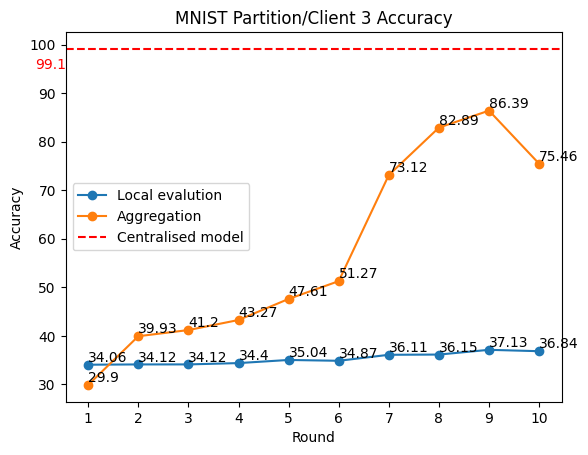

In [17]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"MNIST Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')

average_value = 99.1
plt.gca().text(0, average_value/110, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.show()